<a href="https://colab.research.google.com/github/mtzig/badwriting_OCR/blob/main/Fine_tune_TrOCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/mtzig/badwriting_OCR.git
%cd /content/badwriting_OCR/

Cloning into 'badwriting_OCR'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 49 (delta 18), reused 14 (delta 5), pack-reused 0
Receiving objects: 100% (49/49), 1.57 MiB | 2.11 MiB/s, done.
Resolving deltas: 100% (18/18), done.
/content/badwriting_OCR


In [2]:
!pip install -q transformers

In [3]:
!pip install -q datasets jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 84.4 MB/s eta 0:00:00


## Prepare data

We first download the data. Here, I'm just using the IAM test set, as this was released by the TrOCR authors in the unilm repository. It can be downloaded from [this page](https://github.com/microsoft/unilm/tree/master/trocr).

Let's make a [regular PyTorch dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). We first create a Pandas dataframe with 2 columns. Each row consists of the file name of an image, and the corresponding text.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd

df = pd.read_fwf('/content/drive/MyDrive/IAM/IAM/gt_test.txt', header=None)
df.rename(columns={0: "file_name", 1: "text"}, inplace=True)
del df[2]
# some file names end with jp instead of jpg, let's fix this
df['file_name'] = df['file_name'].apply(lambda x: x + 'g' if x.endswith('jp') else x)
df.head()

In [6]:
import pandas as pd

test_df = pd.read_csv('data/thomas_writing/t_data.csv')
test_df.head()

,file_name,text
0,t1.png,Text recognition is a long standing research p...
1,t2.png,Optical Character Recognition (OCR) is the ele...
2,t3.png,TrOCR is built up with the Transformer archite...
3,t4.png,When loading the above models to the decoders
4,t5.png,The structures do not precisely match


We split up the data into training + testing, using sklearn's `train_test_split` function.

In [7]:
from sklearn.model_selection import train_test_split

train_df, fake_test_df = train_test_split(df, test_size=0.2)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
fake_test_df.reset_index(drop=True, inplace=True)

In [ ]:
_, test_df = train_test_split(df, test_size=0.2)
# we reset the indices to start from zero
#train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

Each element of the dataset should return 2 things:
* `pixel_values`, which serve as input to the model.
* `labels`, which are the `input_ids` of the corresponding text in the image.

We use `TrOCRProcessor` to prepare the data for the model. `TrOCRProcessor` is actually just a wrapper around a `ViTFeatureExtractor` (which can be used to resize + normalize images) and a `RobertaTokenizer` (which can be used to encode and decode text into/from `input_ids`).

In [9]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

Let's initialize the training and evaluation datasets:

In [24]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-handwritten")
train_dataset = IAMDataset(root_dir='/content/drive/MyDrive/IAM/IAM/image/',
                           df=train_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir='./data/thomas_writing/',
                           df=test_df,
                           processor=processor)

preprocessor_config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


tokenizer_config.json:   0%|          | 0.00/327 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

In [25]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 11
Number of validation examples: 3


Let's verify an example from the training dataset:

In [26]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


We can also check the original image and decode the labels:

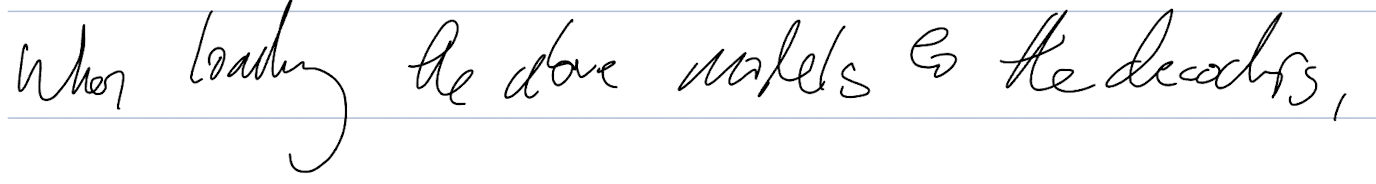

In [27]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image

In [28]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

When loading the above models to the decoders


Let's create corresponding dataloaders:

In [29]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=4)

## Train a model

Here, we initialize the TrOCR model from its pretrained weights. Note that the weights of the language modeling head are already initialized from pre-training, as the model was already trained to generate text during its pre-training stage. Refer to the paper for details.

In [30]:
from transformers import VisionEncoderDecoderModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-handwritten")
model.to(device)

config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(

Importantly, we need to set a couple of attributes, namely:
* the attributes required for creating the `decoder_input_ids` from the `labels` (the model will automatically create the `decoder_input_ids` by shifting the `labels` one position to the right and prepending the `decoder_start_token_id`, as well as replacing ids which are -100 by the pad_token_id)
* the vocabulary size of the model (for the language modeling head on top of the decoder)
* beam-search related parameters which are used when generating text.

In [31]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

We will evaluate the model on the Character Error Rate (CER), which is available in HuggingFace Datasets (see [here](https://huggingface.co/metrics/cer)).

In [32]:
from datasets import load_metric

cer_metric = load_metric("cer")

<ipython-input-32-c81d87c6f9c2>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:753: FutureWarning: The repository for cer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/cer/cer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [33]:
def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

In [ ]:
for pn, p in model.named_parameters():
  if pn != 'decoder.output_projection.weight':
    p.requires_grad = False


for pn, p in model.named_parameters():
  print(pn, p.requires_grad)
  

In [ ]:
for pn, p in model.named_parameters():
  if pn.startswith('encoder'):
    p.requires_grad = False


for pn, p in model.named_parameters():
  print(pn, p.requires_grad)
  

In [34]:
from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

for epoch in range(10):  # loop over the dataset multiple times
   # train
   model.train()
   train_loss = 0.0
   for batch in tqdm(train_dataloader):
      # get the inputs
      for k,v in batch.items():
        batch[k] = v.to(device)

      # forward + backward + optimize
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()

   print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))

   # evaluate
   model.eval()
   valid_cer = 0.0
   with torch.no_grad():
     for batch in tqdm(eval_dataloader):
       # run batch generation
       outputs = model.generate(batch["pixel_values"].to(device))
       # compute metrics
       cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
       valid_cer += cer

   print("Validation CER:", valid_cer / len(eval_dataloader))

model.save_pretrained(".")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after epoch 0: 10.480345726013184


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1339: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


Validation CER: 0.9591836734693877


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after epoch 1: 8.158265113830566


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.7755102040816326


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after epoch 2: 7.416681130727132


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.7687074829931972


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after epoch 3: 7.170210838317871


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.7619047619047619


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after epoch 4: 6.874818007151286


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.7959183673469388


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after epoch 5: 6.610857009887695


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.7687074829931972


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after epoch 6: 6.009253819783528


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.8231292517006803


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after epoch 7: 5.904284795125325


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.7551020408163265


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after epoch 8: 5.087930838267009


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.8231292517006803


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after epoch 9: 4.838818073272705


  0%|          | 0/1 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.8027210884353742


## Inference

Note that after training, you can easily load the model using the .`from_pretrained(output_dir)` method.

For inference on new images, I refer to my inference notebook, that can also be found in my [Transformers Tutorials repository](https://github.com/NielsRogge/Transformers-Tutorials) on Github.

In [49]:

def classify_img(img):
  model.eval()

  pixel_values = processor(images=img, return_tensors="pt").pixel_values.to(device)

  generated_ids = model.generate(pixel_values, max_length=10)
  generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

  print(generated_text)

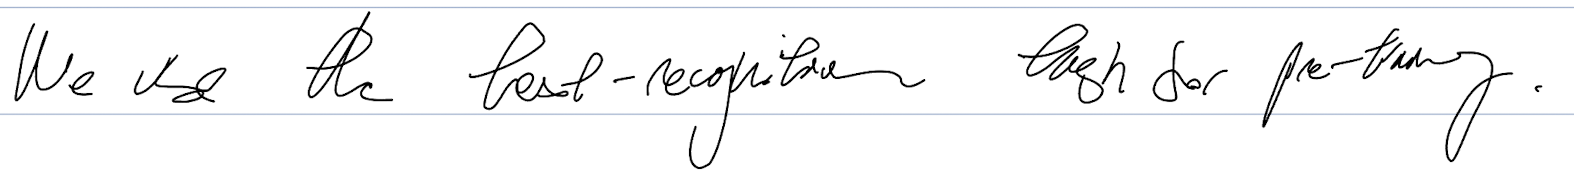

In [40]:
image = Image.open(train_dataset.root_dir + test_df['file_name'][0]).convert("RGB")
image

In [48]:
classify_img(image)

Flags is a large-scale scale-scale
